# Assignment 3 (100 points)

You are expected to complete this notebook with lines of code, plots and texts. You might need to create new cells with original code or text for your analyses. This assignment has a total of 100 points.

For assignment submission, you will submit this notebook file (.ipynb) on Canvas with cells executed and outputs visible. Your submitted notebook **must** follow these guidelines:
- No other dataset than the provided datasets should be used.
- Training, validation and testing splits should be the same as the ones provided.
- The cell outputs in your delivered notebook should be reproducible.
- Please print out the evaluation metric evidence that your model achieves the evaluation requirement. Optionally, you can also add plot of how the evaluation metric changes over the course of training process.
- Please provide code associated with the conclusions you make in your analysis as well as code that is used to generate plots, images, etc. for your analysis.
- All code must be your own work. Code cannot be copied from external sources or another students. You may copy code from cells that are pre-defined in this notebook if you think it is useful to reuse in another question.
- All images must be generated from data in your code. Do **NOT** import/display images that are generated outside your code.
- Your analyses must be your own, but if you quote text or equations from another source please make sure to cite the appropriate references.
- Your input with code will be marked with comments ``###your code starts here###`` and ``###your code ends here###`` to specify where you need to write your code. You can also create a new code cell in between those marked comments.


**NOTES:**
- PyTorch needs to be downloaded and installed properly.
- You should use PyTorch 1.7 or later.
- If you need to import a different package than the ones already imported, please check with the TA if you can do so.
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and comments as they contain variables and information that you may need to use to complete the notebook.
- To create a new text cell, select "+" button on the menu bar and change its type from "Code" to "Markdown".
- To modify a text cell, double click on it.
- More details on how to format markdown text can be found here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- Your home directory on CADE machines has a small disk quota. It might be necessary, depending on how much your home directory is already occupied, to store the virtual environment inside a folder in ```/scratch/tmp/```. 

**Tips for training deep learning models:**
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a GPU's usage report. However, if you are using your own Windows machine, the nvidia-smi command used in the define_gpu_to_use function will not work. You can skip running this function but please check to make sure your GPU has a sufficient amount of free memory.
- Here are a few PyTorch details not to forget:
    - Toggle train/eval mode for your model
    - Reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Reinstantiate your model every time you are starting a new training so that the weights are reset, if you plan to reuse the variable name.
    - Pass the model's parameters to the optimizer.

# Exercise 0 - Setting-up Infrastructure (Total of 0 points)
## + Installing Libraries:
Follow the steps below to install a few more additional libraries:
- Open another terminal and activate your virtual environment ``source your_virtualvenv_name/bin/activate``.
- Install the following libraries via pip using these commands: ``pip install scikit-image``, ``pip install scikit-learn``, ``pip install imageio``, and ``pip install imagecodecs``.

## + Importing Libraries:

In [1]:
import os
import gzip
import shutil
import tarfile
import imageio
import imagecodecs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import collections
from skimage import morphology
from skimage.measure import block_reduce
import scipy
from torch.utils.data import Dataset
import PIL
from PIL import Image
from sklearn.metrics import f1_score
import copy
import random
import math
import torch
from packaging import version

##### Checking Torch library requirement #####
my_torch_version = torch.__version__
minimum_torch_version = '1.7'
if version.parse(my_torch_version) < version.parse(minimum_torch_version):
    print('Warning!!! Your Torch version %s does NOT meet the minimum requirement!\
            Please update your Torch library\n' %my_torch_version)

## + Requesting GPU Usage:

In [2]:
##### Checking the System #####
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False
    
##### Requesting a GPU #####
## This function locates an available gpu for usage. In addition, this function reserves a specificed
## memory space exclusively for your account. The memory reservation prevents the decrement in computational
## speed when other users try to allocate memory on the same gpu in the shared systems, i.e., CADE machines. 
## Note: If you use your own system which has a GPU with less than 4GB of memory, remember to change the 
## specified mimimum memory.
def define_gpu_to_use(minimum_memory_mb = 3500):    
    thres_memory = 600 #
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        
        if free_memory>minimum_memory_mb-thres_memory:
            gpu_to_use = i
            break
            
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' + str(minimum_memory_mb) \
              + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-thres_memory)).cuda()
        x = torch.rand((1,1)).cuda()        
        del x
        
## Request a gpu and reserve the memory space
define_gpu_to_use()

Chosen GPU: 0


# Exercise 1 - DRIVE and STARE Dataset (Total of 100 points)

In this exercise, we are going to implement a segmentation model to extract blood vessels in retinal digital images. We will utilize two well-known retina image datasets, DRIVE (https://www.isi.uu.nl/Research/Databases/DRIVE/) and STARE (http://cecas.clemson.edu/~ahoover/stare/). First, we need to download these datasets. Please follow the steps below to download the images and then put them in the same directory as this notebook:
 - Register an account with DRIVE dataset - https://grand-challenge.org/accounts/login/?next=https%3A//drive.grand-challenge.org/participants/registration/create/
 - Download ``datasets.zip`` file at https://drive.grand-challenge.org/Download/
 - Download ``stare-images.tar`` from http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar
 - Download ``labels-vk.tar`` from http://cecas.clemson.edu/~ahoover/stare/probing/labels-vk.tar

Next, we are going to define a few functions to extract images from the downloaded file for DRIVE and STARE datasets, respectively.

In [3]:
##### Removing Small Regions #####
## This function removes small regions (<size) of a given binary image.
def remove_small_regions(img, size):
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [4]:
##### Resizing Image #####
## This function resizes a given input image to be half of the original size.
def resize_img(img):
    if len(img.shape)==3:
        img = np.array(Image.fromarray(img).resize(((img.shape[1]+1)//2,(img.shape[0]+1)//2), \
                                                   PIL.Image.BILINEAR))
    else:
        img = block_reduce(img, block_size=(2, 2), func=np.max)
    return img

In [5]:
##### DRIVE Dataset Loading Function #####
## This function unzips the downloaded file. Then, it loads the corresponding mask 
## for each image in the DRIVE dataset.
def drive_read_images(filetype, dest_folder):
    zip_ref = zipfile.ZipFile('datasets.zip', 'r')
    zip_ref.extractall('datasets/drive')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('datasets/drive/training.zip', 'r')
    zip_ref.extractall('datasets/drive')
    zip_ref.close()

    all_images = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith(filetype):            
            img = imageio.imread(dest_folder + item)
            if len(img.shape) == 3:
                img = np.pad(img , ((12,12), (69,70),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((12,12), (69,70)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
    return all_images

In [6]:
##### STARE Dataset Loading Function #####
## This function untars the downloaded file. Then, it loads the corresponding mask 
## for each image in the STARE dataset.
def stare_read_images(tar_filename, dest_folder, do_mask = False):
    tar = tarfile.open(tar_filename)
    tar.extractall(dest_folder)
    tar.close()
    all_images = []
    all_masks = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith('gz'):
            with gzip.open(dest_folder + item, 'rb') as f_in:
                with open(dest_folder + item[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            os.remove(dest_folder + item) 
            img = imageio.imread(dest_folder + item[:-3])
            if len(img.shape) == 3:
                img = np.pad(img , ((1,2), (2,2),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((1,2), (2,2)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
            if do_mask:
                mask = (1-remove_small_regions(np.prod((img<50/255.)*1.0, axis = 2)>0.5, 1000))*1.0
                mask = np.expand_dims(mask, axis = 2)
                all_masks.append(mask.astype(np.float32))
    if do_mask:
        return all_images, all_masks
    else:
        return all_images

The DRIVE dataset provides its own split for training and testing. However, the mask images of the test split in DRIVE dataset are currently missing. Thus, we are going to use our own train/validation/test splits with the provided function below. 

In [7]:
##### Spliting a dataset for training, validatation, and testing #####
## This function splits a given dataset into 3 subsets of 70%-10%-20% for train-val-test, 
## respectively, and is used internally in the dataset classes below.
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

## Exercise 1.1 - Data Augmentation (12 points)
Data augmentation is an essential step in training deep models. Using data augmentation usually helps to improve the performance of a deep model. Please write a short reasoning why data augmentation helps to improve the performance.

**Write your answer here:** 
Data augmentation creates more examples of the different labels for use in training that should allow for increased generalization by the model. This happens because markers on the image that shouldn't be used during classification - such as a label in one corner - get moved around and/or cropped out in some examples so the model can't grow to depend on that feature for classification of that example.

For this exercise, we will be using horizontal and vertical flipping. Your task is first to provide a short reasoning why horizontal and vertical flipping is suitable for this dataset. Second, please list at least one other data augmentation method that could also be used for this dataset. 

**Write your answer here:** 
Horizontal and vertical flipping are appropriate for this dataset because: 1) the region of interest is centered within the image so flipping it horizontally and/or vertically will not significantly alter the positioning of the information provided to the model, and 2) the vessels of the retina branch in multiple times and do not head in particular directions so flipping will not remove information from the dataset like it would if the vessels always only moved at a 45 degree angle from the y-axis in unaltered examples.

An additional data augmentation that could be used is a random rotation. If included in addition to flipping it would be useful to limit it to > 1 and < 45 degrees to avoid the potential of completely cancelling out the flip. It could also be used as an augmentation without the possiblity of flipping and any rotation allowed.

Next, you will implement the horizontal and vertical flipping transformations by filling out the missing codes in the code cell below. 

In [8]:
##### Defining Transformations #####
## The transformations below will be applied to input image, segmentation ground-truth and mask.

## Applying transformations to all array in list x 
def _iterate_transforms(transform, x):
    for i, xi in enumerate(x):
        x[i] = transform(x[i])
    return x

## Redefining Pytorch composed transform so that it uses the _iterate_transforms function
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for transform in self.transforms:
            x = _iterate_transforms(transform, x) 
        return x

## Generating randomize odd for vertical flipping class
class RandomVerticalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

## Performing vertical flip using randomization provided by generator class above
class RandomVerticalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            ### Your code starts here ###
            flipped_img = torch.flip(img,[0,1])
            ### Your code ends here ###
            return flipped_img
        return img

## Generating randomize odd for horizontal flipping class  
class RandomHorizontalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

## Performing horizontal flip using randomization provided by generator class above
class RandomHorizontalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            ### Your code starts here ###
            flipped_img = torch.flip(img,[1,0])
            ### Your code ends here ###
            return flipped_img
        return img 

We then create a Pytorch class structure for this dataset. The dataset class is used to load, index, and preprocess samples for training, validation, and testing process.

In [9]:
class RetinaDataset(Dataset):    
    ##### Initializing the class #####
    def __init__(self, retina_array, split = 'train', do_transform=False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        indexes_this_split = get_split(np.arange(len(retina_array), dtype = int), split)
        self.retina_array = [self.transpose_first_index(retina_array[i]) for i in indexes_this_split]
        self.split = split
        self.do_transform = do_transform
        
    ##### Retrieving a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns a list in which the first element is input image to be segmented,
    ## the second element is the segmentation ground truth, and the last element is the mask of image region
    def __getitem__(self, index):
        sample = [torch.FloatTensor(x) for x in self.retina_array[index]]
        if self.do_transform:
            v_gen = RandomVerticalFlipGenerator()
            h_gen = RandomHorizontalFlipGenerator()
            t = Compose([
                v_gen,
                RandomVerticalFlip(gen=v_gen),
                h_gen,
                RandomHorizontalFlip(gen=h_gen),
            ])
            sample = t(sample)
        return sample
    
    ##### Accessing the length of the dataset #####
    def __len__(self):
        return len(self.retina_array)
    
    ##### Flipping the third dimension #####
    def transpose_first_index(self, x):
        x2 = (np.transpose(x[0], [2,0,1]), np.transpose(x[1], [2,0,1]), np.transpose(x[2], [2,0,1]))
        return x2

Now, we utilize the class function above to create structures for each training, validation, and test set.

In [10]:
##### Loading Data #####
## This function loads DRIVE and STARE datasets into a list of list of arrays. 
## The first element in the list is the list of input images, the second element is a list of segmentation
## ground truth, and the last element is a list of masks of image region.
## The original images were padded as squares so that we can fit them to a traditional CNN. 
## The masks are binary images, and contain the location of the original image (labeled as 1) and 
## the padded region (labeled as 0). These masks are used to limit where outputs are backpropagated 
## for trained and which region of the image should be used for scoring. 
def get_retina_array():
    stare_images, stare_mask = stare_read_images("stare-images.tar", 'datasets/stare/images/', do_mask = True)  
    stare_segmentation = stare_read_images("labels-vk.tar", 'datasets/stare/segmentations/')   
    
    drive_training_images = drive_read_images('tif', 'datasets/drive/training/images/')
    drive_training_segmentation = drive_read_images('gif', 'datasets/drive/training/1st_manual/')
    drive_training_mask = drive_read_images('gif', 'datasets/drive/training/mask/')
    
    return list(zip(stare_images+drive_training_images,#+drive_test_images, 
                           stare_segmentation+drive_training_segmentation,#+drive_test_segmentation, 
                           stare_mask + drive_training_mask))# + drive_test_mask))

In [11]:
retina_array = get_retina_array()

train_dataset = RetinaDataset(retina_array, do_transform = True)
val_dataset = RetinaDataset(retina_array, split = 'val')
test_dataset = RetinaDataset(retina_array, split = 'test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

Let's visulize a few samples to get ourselves familiar with the type of images we are working with in this exercise. 

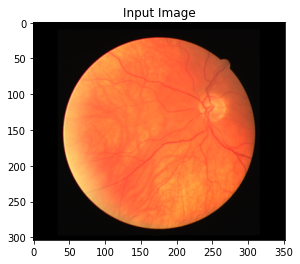

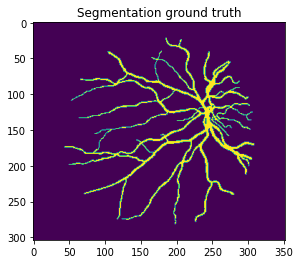

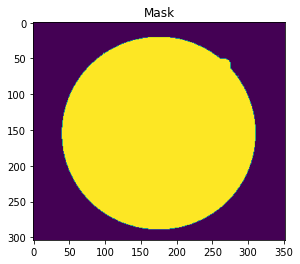

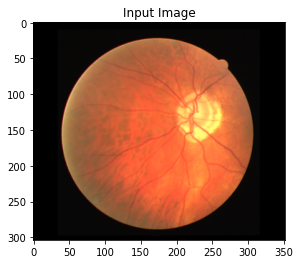

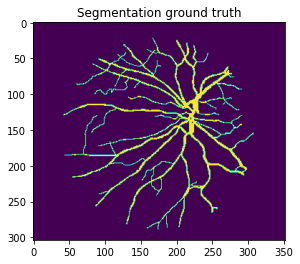

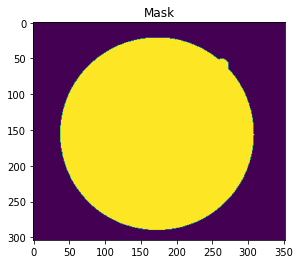

In [12]:
## Visualing a few cases in the training set
for batch_idx, (data, segmentation, mask) in enumerate( RetinaDataset(retina_array)):
    if batch_idx%15 == 0: 
        plt.figure()
        plt.title("Input Image")
        plt.imshow(data[:,:,:].permute([1,2,0]).cpu().numpy())
        plt.figure()
        plt.title("Segmentation ground truth")
        plt.imshow(segmentation[0,:,:].cpu().numpy())
        plt.figure()
        plt.title("Mask")
        plt.imshow(mask[0,:,:].cpu().numpy())
    

We are going to use F1 score to evaluate the segmentation results. The F1 score is computed from precision and recall, and has value between 0 (the worst possible value) and 1 (the best possible value). More information about F1 score can be found here - https://en.wikipedia.org/wiki/F-score. For this exercise, we consider the foreground as positive class and the background as negative class in computing F1 score. 

In [13]:
##### Calculating F1 metric #####
def get_score_model(model, data_loader):
    ## Toggling model to eval mode
    model.eval()
    
    ## Turning off gradients
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1, 304, 352])
        segmentations = np.zeros([0, 1, 304, 352])
        
        mean_f1 = 0.0
        ## Iterating through the dataset and perform inference for each sample.
        ## Then, the F1 score is computed for each sample. 
        for image, segmentation, mask  in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logit_predicted = logit_predicted.cpu().detach().numpy()*mask.numpy()
            segmentation = segmentation.numpy()*mask.numpy()
            
            ## Computing F1 score for each sample in the batch
            for i in range(segmentation.shape[0]):
                curr_seg = segmentation[i,...].reshape([-1])
                curr_logit = logit_predicted[i,...].reshape([-1]) > 0   
                curr_f1 = f1_score(curr_seg, curr_logit)
                mean_f1 += curr_f1
                
    ## Returning the mean F1 of the entire dataset
    return mean_f1/len(data_loader.dataset)

## Exercise 1.2 - Computing Weight Vector (7 points)
In many real world applications, the dataset tends to be imbalanced. It is also the case for this retina image dataset. In this dataset, there are more background samples than there are foreground samples. In this exercise, your task is to examine the imbalanced between foreground and background by providing the following analyses:
- The percentage of positive label (foreground) in this dataset.
- The ratio of negative label (background) to positive label (foreground). 

In [14]:
### Your code starts here ##
ratio = []
pos_perc = []
for image,segmentation,mask in train_loader:
    for k in range(segmentation.shape[0]):
        total_pix = torch.sum(mask[k,...].reshape([-1])).numpy()
        pos_lab = torch.sum(segmentation[k,...].reshape([-1]) > 0).numpy()
        neg_lab = total_pix - pos_lab
        pos_perc.append(pos_lab/total_pix)
        ratio.append(neg_lab/pos_lab)
pos_perc = np.mean(pos_perc)*100
avg_ratio = np.mean(ratio)
print("Positive Label Percentage: %.3f" %(pos_perc))
LossWeight = torch.tensor(avg_ratio)
print("Ratio of negative to positive label: %.3f" %(avg_ratio))
### Your code ends here ###

Positive Label Percentage: 18.135
Ratio of negative to positive label: 4.873


- The percentage of positive label (foreground): **18.13%**.
- The ratio of negative label (background) to positive label (foreground): **4.873:1**.

Now, we are going to use the ratio of negative label to positive label as weight vector for the loss function. In the code cell below, please provide an implementation of a weighted loss function for a binary classification problem.

In [15]:
### Your code starts here ###
loss = torch.nn.BCEWithLogitsLoss(weight = LossWeight)
### Your code ends here ###

## Exercise 1.3 - Implementing U-Net (55 points)
In this section, you are going to implement a well-known segmentation model, called U-Net. Your implementation should follow the architecture as described in the paper (https://arxiv.org/pdf/1505.04597.pdf - Fig. 1 and Section 2) with a few modifications below:
- The input should have 3 channels, and the output should have only one channel (binary output).
- Adding 2D batch normalization layer between convolution layer and Relu transformation, i.e., changing CONV->RELU to CONV->BN->RELU.
- Padding the convolution layers so that the outputs of the convolution layers have the same spatial size as the inputs. With this modification, the cropping operation before the concatenation in the skip connection can be removed.
- Upsampling operation should be implemented with the torch.nn.ConvTransposed2D layer. More details to understand what they meant in the paper can be found in the video here (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) starting at 2:22.
- Reducing the number of channels of **ALL** internal layers 4 times. For example, the number of channels in the first convolution layer in the paper is 64. The first convolution layer in your implementation should have 16 channels instead. 
- No need to implement the initialization of weights as described in the paper. The default weight initialization from Pytorch is sufficient. 
- Your U-Net implementation should be named ``model_ex13`` and the best model should be called ``best_model_ex13``.
- Your implementation of U-Net should achieve an F1 score of at least 0.75 on the validation set.

In [23]:
### Your code starts here ###
class ConvSteps(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(ConvSteps,self).__init__()
        self.conv = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace = True),
        torch.nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace = True),)
    def forward(self,x):
        return self.conv(x)  
    
class ex13_Unet(torch.nn.Module):
    def __init__(
            self,in_channels = 3, out_channels = 1, intermediate_channels = [16,32,64,128],
    ):
        super(ex13_Unet, self).__init__()
        self.down_layers = torch.nn.ModuleList()
        self.up_layers = torch.nn.ModuleList()
        for inter_channels in intermediate_channels:
            self.down_layers.append(ConvSteps(in_channels,inter_channels))
            in_channels = inter_channels
        self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        for inter_channels in reversed(intermediate_channels):
            self.up_layers.append(torch.nn.ConvTranspose2d(inter_channels*2,inter_channels,kernel_size = 2,
                                                          stride = 2))
            self.up_layers.append(ConvSteps(inter_channels*2,inter_channels))
        
        self.bottom = ConvSteps(intermediate_channels[-1],intermediate_channels[-1]*2)
        self.finalStep = torch.nn.Conv2d(intermediate_channels[0],out_channels,kernel_size = 1)
    
    def forward(self,step_output):
        skip_connections = []
        for steps in self.down_layers:
            step_output = steps(step_output)
            skip_connections.append(step_output)
            step_output = self.pool(step_output)
        step_output = self.bottom(step_output)
        skip_connections = skip_connections[::-1]
        for step in range(0,len(self.up_layers),2):
            step_output = self.up_layers[step](step_output)
            skip = skip_connections[step//2]
            skip_output = torch.cat((skip,step_output),dim = 1)
            step_output = self.up_layers[step+1](skip_output)
        return self.finalStep(step_output)
    
model_ex13 = ex13_Unet(in_channels = 3, out_channels = 1)
model_ex13 = model_ex13.cuda()
### Your code ends here ###

Next, your task is to complete the ``training_stage`` function below. You must use the provided masks when computing the loss. In other words, you must only compute the loss for the pixels that have values of 1 in the corresponding mask images.

In [24]:
def training_stage(epoch, optimizer, loss, model, train_loader, val_loader):
    model.train()
    loss_values = []
    for batch_idx, (data, segmentation, mask) in enumerate(train_loader):
        ### Your code starts here ###
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            data = data.cuda()
            segmentation = segmentation.cuda()
            mask = mask.cuda()
            outputs = model(data)
            masked_output = outputs*mask
            masked_seg = segmentation*mask
            loss_value = loss(masked_output,masked_seg)
            loss_value.backward()
            optimizer.step()
        ### Your code ends here ###
        loss_values.append(loss_value.item())
    return np.mean(loss_values)

In [25]:
optimizer = torch.optim.SGD(model_ex13.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200

## Using the scheduler module to reduce the learning rate after reaching a plateau. 
## More information about the scheduler can be found at 
## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)
current_best_score = -1

for epoch in range(n_epochs):
    ## Train the model
    loss_value = training_stage(epoch, optimizer, loss, model_ex13, train_loader, val_loader)
    ## Evaluate the current model
    f1_val = get_score_model(model_ex13, val_loader)
    f1_train = get_score_model(model_ex13, train_loader)
    current_score = f1_val
    ## Save the model
    if current_score > current_best_score:
        current_best_score = current_score
        best_model_ex13 = copy.deepcopy(model_ex13)
    print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
    print('F1 train: {:.5f} \t F1 val: {:.5f}'.format(f1_train, f1_val))
    ## Activate scheduler
    scheduler.step()

Train Epoch: 0 	Loss: 3.02801
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 1 	Loss: 2.77603
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 2 	Loss: 2.71724
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 3 	Loss: 2.72321
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 4 	Loss: 2.67451
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 5 	Loss: 2.66400
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 6 	Loss: 2.63956
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 7 	Loss: 2.60982
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 8 	Loss: 2.55557
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 9 	Loss: 2.50147
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 10 	Loss: 2.48598
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 11 	Loss: 2.47208
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 12 	Loss: 2.38734
F1 train: 0.00138 	 F1 val: 0.00119
Train Epoch: 13 	Loss: 2.34707
F1 train: 0.07429 	 F1 val: 0.07513
Train Epoch: 14 	Loss: 2.33379
F1 train: 0.28024 	 F1 val: 0.37518
Train

Train Epoch: 123 	Loss: 1.67319
F1 train: 0.83837 	 F1 val: 0.78555
Train Epoch: 124 	Loss: 1.68697
F1 train: 0.83110 	 F1 val: 0.76929
Train Epoch: 125 	Loss: 1.67103
F1 train: 0.84175 	 F1 val: 0.77791
Train Epoch: 126 	Loss: 1.65726
F1 train: 0.83064 	 F1 val: 0.76324
Train Epoch: 127 	Loss: 1.65976
F1 train: 0.81669 	 F1 val: 0.78472
Train Epoch: 128 	Loss: 1.69060
F1 train: 0.80549 	 F1 val: 0.75827
Train Epoch: 129 	Loss: 1.67402
F1 train: 0.83389 	 F1 val: 0.77278
Train Epoch: 130 	Loss: 1.65460
F1 train: 0.77750 	 F1 val: 0.71880
Train Epoch: 131 	Loss: 1.67495
F1 train: 0.84648 	 F1 val: 0.78309
Train Epoch: 132 	Loss: 1.66713
F1 train: 0.82723 	 F1 val: 0.76077
Train Epoch: 133 	Loss: 1.64506
F1 train: 0.82915 	 F1 val: 0.75988
Train Epoch: 134 	Loss: 1.63054
F1 train: 0.84821 	 F1 val: 0.78193
Train Epoch: 135 	Loss: 1.64803
F1 train: 0.84379 	 F1 val: 0.78238
Train Epoch: 136 	Loss: 1.64092
F1 train: 0.84582 	 F1 val: 0.77711
Train Epoch: 137 	Loss: 1.64532
F1 train: 0.8441

Lastly, let's evaluate the trained model on the test set.

In [26]:
print('F1 score of test set: {:.5f}'.format(get_score_model(best_model_ex13, test_loader)))

F1 score of test set: 0.77071


## Exercise 1.4 - Visualizing Output (8 points)
In this section, please plot the predicted output of a few samples from the validation set as well as the corresponding ground-truth. In addition, please provide a short analysis on the type of mistakes that you are able to distinguish. For example, where in the image does the model wrongly identify as foreground? where in the image does the model wrongly identfy as background?

**Write your analysis here**:
Incorrect classification as foreground occurs at the edge of the mask in some images. When this happens the incorrect foreground classification often occurs following along this edge for a distance (first and third image set below). Another area where this incorrected identification of foreground pixels occurs is in images that have an uneven distribution of small diameter vessels which leads to areas without them potentially being predicted as having them (second image set below).

Incorrect identification of pixels as background happens at with very small diameter vessels and at the junctions between larger diameter vessels and smaller vessels. This incorrect classification results in entirely missing regions of small diameter vessels and floating vessels that are present in the ground truth but aren't connected to the other vasculature in the prediction.

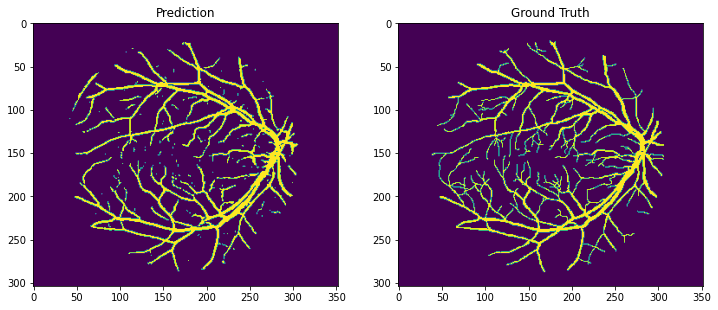

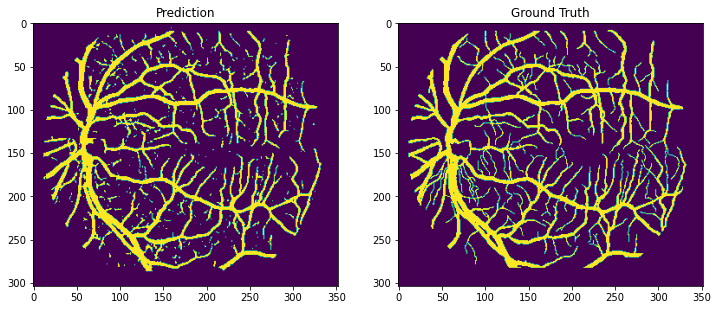

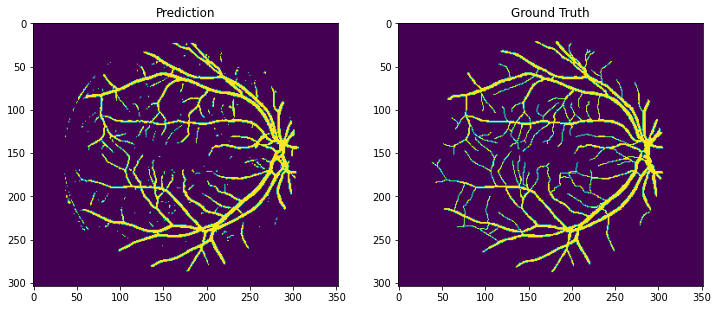

In [27]:
### Your code starts here ###
for k in range(3):
    curr_data, curr_segmentation,curr_mask = val_loader.dataset[k]
    curr_out = best_model_ex13(curr_data.cuda().unsqueeze(0))
    curr_pred = torch.sigmoid(curr_out)
    pred_ones = torch.from_numpy(np.ones(curr_segmentation.shape)).cuda()
    curr_pred_vals = curr_pred > 0.5
    curr_pred_vals = pred_ones*curr_pred_vals
    prediction = curr_pred_vals.detach().cpu()[0,0,:,:]
    gt = curr_segmentation.detach().cpu()
    fig,ax = plt.subplots(1,2,figsize=(12,12))
    ax[0].imshow(prediction)
    ax[0].set_title("Prediction")
    ax[1].imshow(gt[0,:,:])
    ax[1].set_title("Ground Truth")
### Your code ends here ###

## Exercise 1.5 - Implementing U-Net Without Skip Connections (18 points)
In this section, your task is to implement a similar U-Net model, called ``model_ex15``, as specificed in Exercise 1.3 with the exception that this model does **NOT** contain any skip connections. To compensate for not having the extra channels coming from the skip connection, you need to double the number of output channels in the upsampling layer. 

**Notes:**
- Your best model should be named ``best_model_ex15``.
- Your implementation of this variant should achieve an F1 score of at least 0.5.

In [28]:
### Your code starts here ###
class ConvSteps(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(ConvSteps,self).__init__()
        self.conv = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace = True),
        torch.nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace = True),)
    def forward(self,x):
        return self.conv(x)  
    
class ex15_Unet(torch.nn.Module):
    def __init__(
            self,in_channels = 3, out_channels = 1, intermediate_channels = [16,32,64,128],
    ):
        super(ex15_Unet, self).__init__()
        self.down_layers = torch.nn.ModuleList()
        self.up_layers = torch.nn.ModuleList()
        for inter_channels in intermediate_channels:
            self.down_layers.append(ConvSteps(in_channels,inter_channels))
            in_channels = inter_channels
        self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        for inter_channels in reversed(intermediate_channels):
            self.up_layers.append(torch.nn.ConvTranspose2d(inter_channels*2,inter_channels*2,kernel_size = 2,
                                                          stride = 2))
            self.up_layers.append(ConvSteps(inter_channels*2,inter_channels))
        
        self.bottom = ConvSteps(intermediate_channels[-1],intermediate_channels[-1]*2)
        self.finalStep = torch.nn.Conv2d(intermediate_channels[0],out_channels,kernel_size = 1)
    
    def forward(self,step_output):
        for steps in self.down_layers:
            step_output = steps(step_output)
            step_output = self.pool(step_output)
        step_output = self.bottom(step_output)
        for step in range(0,len(self.up_layers),2):
            step_output = self.up_layers[step](step_output)
            step_output = self.up_layers[step+1](step_output)
        return self.finalStep(step_output)
    
model_ex15 = ex15_Unet(in_channels = 3, out_channels = 1)
model_ex15 = model_ex15.cuda()
### Your code ends here ###

Now, let's train the implemented model above.

In [29]:
optimizer = torch.optim.SGD(model_ex15.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

current_best_score = -1
for epoch in range(n_epochs):
    ## Train the model
    loss_value = training_stage(epoch, optimizer, loss, model_ex15, train_loader, val_loader)
    f1_val = get_score_model(model_ex15, val_loader)
    f1_train = get_score_model(model_ex15, train_loader)
    current_score = f1_val
    ## Save the model
    if current_score > current_best_score:        
        current_best_score = current_score
        best_model_ex15 = copy.deepcopy(model_ex15)
    print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
    print('F1 train: {:.5f} \t F1 val: {:.5f}'.format(f1_train, f1_val))
    ## Activate scheduler
    scheduler.step()

Train Epoch: 0 	Loss: 3.05720
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 1 	Loss: 2.81389
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 2 	Loss: 2.73798
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 3 	Loss: 2.73274
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 4 	Loss: 2.72960
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 5 	Loss: 2.70391
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 6 	Loss: 2.70034
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 7 	Loss: 2.70110
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 8 	Loss: 2.70590
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 9 	Loss: 2.69919
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 10 	Loss: 2.69335
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 11 	Loss: 2.69105
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 12 	Loss: 2.67612
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 13 	Loss: 2.66227
F1 train: 0.00000 	 F1 val: 0.00000
Train Epoch: 14 	Loss: 2.64745
F1 train: 0.00000 	 F1 val: 0.00000
Train

Train Epoch: 123 	Loss: 1.88975
F1 train: 0.75119 	 F1 val: 0.48962
Train Epoch: 124 	Loss: 1.90710
F1 train: 0.75020 	 F1 val: 0.48035
Train Epoch: 125 	Loss: 1.89309
F1 train: 0.75489 	 F1 val: 0.48844
Train Epoch: 126 	Loss: 1.88319
F1 train: 0.75256 	 F1 val: 0.48892
Train Epoch: 127 	Loss: 1.89103
F1 train: 0.76195 	 F1 val: 0.47705
Train Epoch: 128 	Loss: 1.89350
F1 train: 0.74186 	 F1 val: 0.48598
Train Epoch: 129 	Loss: 1.87398
F1 train: 0.76270 	 F1 val: 0.49826
Train Epoch: 130 	Loss: 1.84652
F1 train: 0.72804 	 F1 val: 0.46874
Train Epoch: 131 	Loss: 1.83704
F1 train: 0.76867 	 F1 val: 0.48441
Train Epoch: 132 	Loss: 1.84372
F1 train: 0.78306 	 F1 val: 0.48798
Train Epoch: 133 	Loss: 1.81423
F1 train: 0.76763 	 F1 val: 0.47964
Train Epoch: 134 	Loss: 1.82005
F1 train: 0.76839 	 F1 val: 0.48200
Train Epoch: 135 	Loss: 1.83615
F1 train: 0.73765 	 F1 val: 0.47463
Train Epoch: 136 	Loss: 1.84021
F1 train: 0.75188 	 F1 val: 0.46270
Train Epoch: 137 	Loss: 1.84486
F1 train: 0.7771

Lastly, let's evaluate the trained model on the test set.

In [30]:
print('F1 score of test set: {:.5f}'.format(get_score_model(best_model_ex15, test_loader)))

F1 score of test set: 0.48285


Again, please provide a similar visualization as Exercise 1.4.

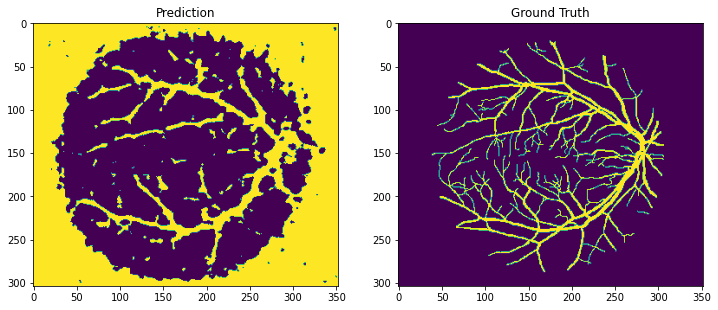

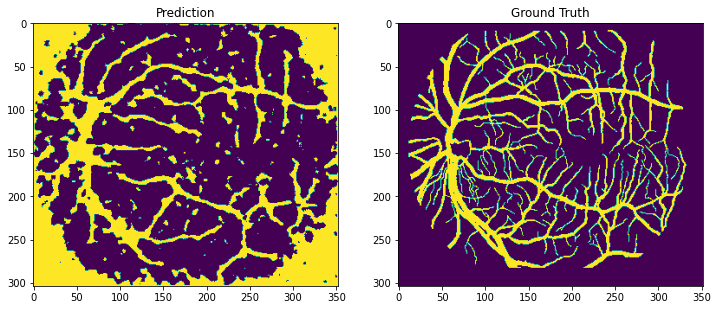

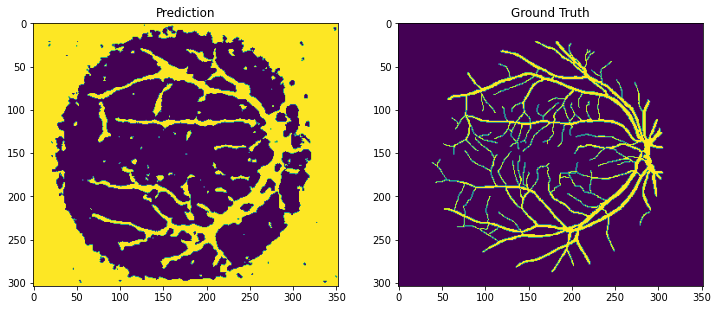

In [31]:
### Your code starts here ###
for k in range(3):
    curr_data, curr_segmentation,curr_mask = val_loader.dataset[k]
    curr_out = best_model_ex15(curr_data.cuda().unsqueeze(0))
    curr_pred = torch.sigmoid(curr_out)
    pred_ones = torch.from_numpy(np.ones(curr_segmentation.shape)).cuda()
    curr_pred_vals = curr_pred > 0.5
    curr_pred_vals = pred_ones*curr_pred_vals
    prediction = curr_pred_vals.detach().cpu()[0,0,:,:]
    gt = curr_segmentation.detach().cpu()
    fig,ax = plt.subplots(1,2,figsize=(12,12))
    ax[0].imshow(prediction)
    ax[0].set_title("Prediction")
    ax[1].imshow(gt[0,:,:])
    ax[1].set_title("Ground Truth")
### Your code ends here ###

As seen qualitatively from the visualization section and quantitatively from the F1 score, the U-Net model without skip connections performs poorly specifically in the thin section of the foreground. In the cell below, please provide a short reasonsing of 1) which causes the model to performance poorly in the thin section of the foreground? 2) Why the skip connections help to overcome that limitation?

**Write your answer here**:
1)The decrease in resolution during the max pooling layers in the downwards side of U-Net results in fine scale information being lost. When the image is then scaled back up to its original resolution little of the information provided by the thin vessels early is able to be taken into account during the transpose convolutions which results in these thin vessels not being present in the final image.

2) Skip connections help to overcome that limitation because they restate the information originally found at that dimension and allow it to be taken into account during the classification phase. This allows the classifier to take into acount the position of the thin vessels and the convolutional layers and downscaling/upscaling allow the overall context of that position within the overall region/image. 